## A more clean notebook

In [2]:
# Load all packages
import torch
import torchvision
import torchvision.transforms as transforms
import os
import numpy as np
     
from torchvision.io import read_image
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import matplotlib
from torch import nn
import neptune.new as neptune

### Start the neptune run

In [3]:
# Get the APi key, from outside the git folder.
file = open("../API-key.txt", "r")
key = file.readlines()

run = neptune.init(
    project="Facemask-project/Facemask",
    api_token=key[0])

# Choose the device:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

https://app.neptune.ai/Facemask-project/Facemask/e/FAC-8
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


## Create the dataloader

This Dataloader is using read_image, which is not the fastest way to load files. It might be better to use the cv2 library.

In [4]:

#Create the data loader. This data
class DataLoader(Dataset):
    def __init__(self, img_dir, img_dir2, transform = None, target_transform=None):
        self.img_dir = img_dir
        self.img_dir2 = img_dir2
        self.transform = transform
        self.fileNames = os.listdir(img_dir)
    def __len__(self):
        return len(os.listdir(self.img_dir))

    def __getitem__(self, idx):
        label = self.fileNames[idx].rsplit("t-mask-", 1 )[1]
        img_path = os.path.join(self.img_dir, self.fileNames[idx])
        img_path2 = os.path.join(self.img_dir2, label)
        image = read_image(img_path)
        image2 = read_image(img_path2)
        image = image.clone().detach().float()
        image2 = image2.clone().detach().float()
        if self.transform:
            image = self.transform(image)
            image2 = self.transform(image2)
        return image, image2

## Set up the dataLoader

In [5]:
#Choose batch_size:
batch_size = 25

#create transformer with mean = 0 and std = 1.
transformer=transforms.Compose([ transforms.Normalize((0, 0, 0), (1, 1, 1)),])

#Create the dataset with the dataloader:
dataset = DataLoader("Data_small/50_with_mask", "Data_small/50_without_mask", transform = transformer) 

# split the dataset into test and train set.
test_size = int(0.2 * len(dataset))
train_size = len(dataset) - test_size
test_train_split = [test_size, train_size]
testdata, traindata = torch.utils.data.random_split(dataset = dataset, lengths = test_train_split)

# Set up dataloader and the test
trainloader = torch.utils.data.DataLoader(traindata, 
                                          batch_size=batch_size, 
                                          shuffle=True, 
                                          num_workers=0)
testloader = torch.utils.data.DataLoader(testdata, 
                                          batch_size=1, 
                                          shuffle=True, 
                                          num_workers=0)
dataiter = iter(trainloader)


## Set up the network

In [6]:
# with auto encoder:

import torch.nn.functional as F
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
           
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(1728,2500)
        self.linear2 = nn.Linear(2500,1600)
        self.linear3 = nn.Linear(1600,1200)

        
        self.unflatten = nn.Unflatten(dim =1, unflattened_size = (12,10,10))
        #Encoder
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)  
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 44, 3, padding=1)
        self.conv4 = nn.Conv2d(44, 32, 3, padding=1)
        self.conv5 = nn.Conv2d(32, 16, 3, padding=1)
        self.conv6 = nn.Conv2d(16, 12, 3, padding=1)
       
        self.pool = nn.MaxPool2d(2, 2)
        
        #Decoder
        self.t_conv1 = nn.ConvTranspose2d(12, 16, 3, stride=3, padding= 2)
        self.t_conv2 = nn.ConvTranspose2d(16, 32, 3, stride=2, padding = 2)
        self.t_conv3 = nn.ConvTranspose2d(32, 16 , 3, stride=1, padding = 1)
        self.t_conv4 = nn.ConvTranspose2d(16, 8, 2, stride=1)
        self.t_conv5 = nn.ConvTranspose2d(8, 3, 3, stride=1, padding = 1)
    
    def encode(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = self.pool(x)
        x = F.relu(self.conv6(x))
        return x
    
    def flatlayer(self, x):
        x = self.flatten(x)
        x = F.relu(x)
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        x = F.relu(x)
        x = self.linear3(x)
        x = F.relu(x)
        return x
    
    def decode(self, x):
        x = self.unflatten(x)
        x = F.relu(self.t_conv1(x))
        x = F.relu(self.t_conv2(x))
        x = F.relu(self.t_conv3(x))
        x = F.relu(self.t_conv4(x))
        x = F.relu(self.t_conv5(x))
        return x
        
    def forward(self, x):
        x = self.encode(x)
        x = self.flatlayer(x)
        x = self.decode(x)      
        return x


#Instantiate the model
model = ConvAutoencoder()

#Send the model to the device
model.to(device)


ConvAutoencoder(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=1728, out_features=2500, bias=True)
  (linear2): Linear(in_features=2500, out_features=1600, bias=True)
  (linear3): Linear(in_features=1600, out_features=1200, bias=True)
  (unflatten): Unflatten(dim=1, unflattened_size=(12, 10, 10))
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 44, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(44, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(16, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (t_conv1): ConvTranspose2d(12, 16, kernel_size=(3, 3), stride=(3, 3), padding=(2, 2))
  (t_conv2): ConvTranspose2d(16, 32,

### Set up the neptune parameters

In [7]:
learning_rate = 0.001
#Loss function
criterion = torch.nn.MSELoss()

#Optimizer

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

run["parameters"] = {"lr": learning_rate,
                     "optim": str(optimizer).split(" ")[0],
                     "loss_function" : str(criterion),
                     "Batch_size": batch_size}

### Create the training function

In [8]:
#Epochs
def train(model, n_epochs = 10, criterion = criterion, optimizer = optimizer, trainloader = trainloader):
    for epoch in range(1, n_epochs+1):
        # monitor training loss
        train_loss = 0.0

        #Training
        for data in trainloader:
            mask_image, image = data
            mask_image , image = mask_image.to(device), image.to(device)
            image = image.clone().detach().float()
            mask_image = mask_image.clone().detach().float()
            optimizer.zero_grad()
            outputs = model(mask_image)
            loss = criterion(outputs, image)
            loss.backward()
            optimizer.step()
        if (epoch % 1 == 0):
            train_loss += loss.item()
            print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))
            run["train/loss"].log(train_loss)
           

### Train the model

In [26]:
train(model, n_epochs = 5)

Epoch: 1 	Training Loss: 466.777985
Epoch: 2 	Training Loss: 504.592651
Epoch: 3 	Training Loss: 476.594055
Epoch: 4 	Training Loss: 496.668365
Epoch: 5 	Training Loss: 497.486420


### function to print images:

In [10]:
def print_image(image, model, correct_image):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    ax1.imshow(np.transpose(image.numpy(), (1, 2, 0)).astype('uint8'))
    ax2.imshow(np.transpose(correct_image.numpy(), (1, 2, 0)).astype('uint8'))
    image = torch.unsqueeze(image,0)
    image = image.clone().detach().float()
    image = image.to(device)
    output = model(image)
    output = torch.squeeze(output,0)
    if device.type == 'cuda':
        output = torch.Tensor.cpu(output).clone().detach().numpy()
    else:
        output = output.clone().detach().numpy()
        

    ax3.imshow(np.transpose(output, (1, 2, 0)).astype('uint8'))
    plt.show()

In [11]:
dataiter = iter(testloader)

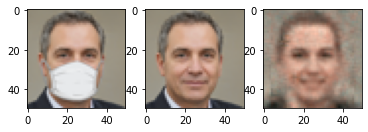

In [25]:
#Test a Model
images, images2 = dataiter.next()
#print_image(images[0], model = model2, correct_image = images2[0])
print_image(images[0], model = model, correct_image = images2[0])

### Stop the run

In [93]:
run.stop()

Shutting down background jobs, please wait a moment...
Done!


Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.


All 1 operations synced, thanks for waiting!


## check speed of code:

In [ ]:
#%load_ext line_profiler

In [50]:
#%lprun -f train train(model, n_epochs = 1)

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler
Epoch: 1 	Training Loss: 432.126851


In [ ]:
torch.save("neptune1_50_40_ep")